In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Função para calcular a distância de Mahalanobis
def distancia_mahalanobis(ponto, media, inv_cov):
    delta = ponto - media
    return np.sqrt(np.dot(np.dot(delta.T, inv_cov), delta))

# Inicialização dos centróides
def inicializar_centroides(dados, k):
    indices = np.random.choice(dados.shape[0], k, replace=False)
    return dados[indices]

# Atribui os pontos ao centróide mais próximo
def atribuir_clusters(dados, centroides, inv_cov):
    clusters = []
    for ponto in dados:
        distancias = [distancia_mahalanobis(ponto, centroide, inv_cov) for centroide in centroides]
        clusters.append(np.argmin(distancias))
    return np.array(clusters)

In [24]:

def atualizar_centroides(dados, clusters, k, centroides_atuais):
    novos_centroides = []
    for i in range(k):
        pontos_cluster = dados[clusters == i]
        if len(pontos_cluster) > 0:
            novos_centroides.append(pontos_cluster.mean(axis=0))
        else:
            # Se o cluster estiver vazio, mantém o centróide original ou reinicializa
            novos_centroides.append(centroides_atuais[i])
    return np.array(novos_centroides)

# Calculando o erro de reconstrução
def erro_reconstrucao(dados, clusters, centroides, inv_cov):
    erro = 0
    for i, ponto in enumerate(dados):
        erro += distancia_mahalanobis(ponto, centroides[clusters[i]], inv_cov) ** 2
    return erro


def k_medias(dados, k, inv_cov, max_iter=100):
    centroides = inicializar_centroides(dados, k)
    for _ in range(max_iter):
        clusters = atribuir_clusters(dados, centroides, inv_cov)
        novo_centroides = atualizar_centroides(dados, clusters, k, centroides)
        if np.all(centroides == novo_centroides):
            break
        centroides = novo_centroides
    erro = erro_reconstrucao(dados, clusters, centroides, inv_cov)
    return clusters, centroides, erro


In [25]:
# Calculando o índice Davies-Bouldin (DB)
def indice_db(dados, clusters, centroides, inv_cov):
    n_clusters = len(centroides)
    dispersoes = np.zeros(n_clusters)
    for i in range(n_clusters):
        pontos_cluster = dados[clusters == i]
        if len(pontos_cluster) > 0:
            dispersoes[i] = np.mean([distancia_mahalanobis(p, centroides[i], inv_cov) for p in pontos_cluster])

    db_index = 0
    for i in range(n_clusters):
        max_ratio = 0
        for j in range(n_clusters):
            if i != j:
                distancia_centroides = distancia_mahalanobis(centroides[i], centroides[j], inv_cov)
                ratio = (dispersoes[i] + dispersoes[j]) / distancia_centroides
                max_ratio = max(max_ratio, ratio)
        db_index += max_ratio
    return db_index / n_clusters


In [26]:
# Avaliar o melhor K para K-médias
def avaliar_k_medias(dados, inv_cov, k_min=4, k_max=20, repeticoes=20):
    melhor_k = None
    melhor_clusters = None
    melhor_centroides = None
    melhor_db = float('inf')

    for k in range(k_min, k_max+1):
        melhor_erro = float('inf')
        melhor_clusters_k = None
        melhor_centroides_k = None

        for _ in range(repeticoes):
            clusters, centroides, erro = k_medias(dados, k, inv_cov)
            if erro < melhor_erro:
                melhor_erro = erro
                melhor_clusters_k = clusters
                melhor_centroides_k = centroides

        db_index = indice_db(dados, melhor_clusters_k, melhor_centroides_k, inv_cov)

        if db_index < melhor_db:
            melhor_db = db_index
            melhor_k = k
            melhor_clusters = melhor_clusters_k
            melhor_centroides = melhor_centroides_k

    return melhor_k, melhor_clusters, melhor_centroides


In [27]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/quake.csv')

dados = df.values

dados_normalizados = (dados - np.mean(dados, axis=0)) / np.std(dados, axis=0)

# Calcular a matriz de covariância e sua inversa
cov_matrix = np.cov(dados_normalizados.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

melhor_k, melhor_clusters, melhor_centroides = avaliar_k_medias(dados_normalizados, inv_cov_matrix)


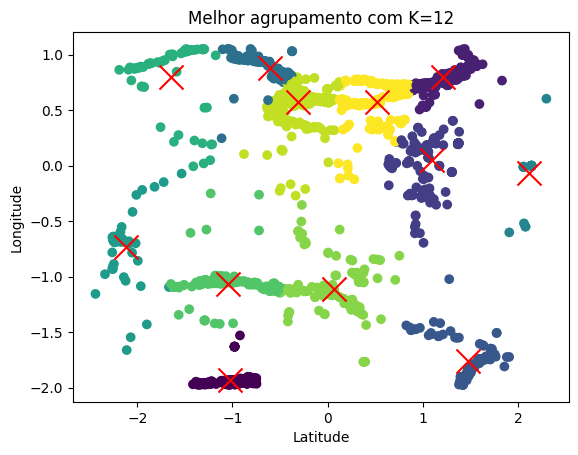

In [28]:
# Plotando o resultado
plt.scatter(dados_normalizados[:, 0], dados_normalizados[:, 1], c=melhor_clusters, cmap='viridis')
plt.scatter(melhor_centroides[:, 0], melhor_centroides[:, 1], s=300, c='red', marker='x')
plt.title(f'Melhor agrupamento com K={melhor_k}')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()